In [2]:
from fastai.vision.all import *
import albumentations

In [3]:
from pathlib import Path
import os
# Check if running in a Kaggle environment
is_kaggle = False
if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    is_kaggle = True
else:
    is_kaggle = False

is_kaggle
Config = {
    'path': Path('./data') if not is_kaggle else Path('../input/paddy-disease-classification'), 
    'model1': 'convnext_small_in22k', 
    'bs': 64, 
    'seed': 42
}
Config['path']

Path('data')

## Custom transformation

In [4]:
class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)
    
def get_train_aug(size): return albumentations.Compose([
            albumentations.RandomResizedCrop(size,size, scale=0.75),
            albumentations.Transpose(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5),
            albumentations.CoarseDropout(p=0.5),
])

def get_valid_aug(): return albumentations.Compose([
    albumentations.CenterCrop(224,224, p=1.),
    albumentations.Resize(224,224)
], p=1.)

In [5]:
Resize(128).__getattribute__('size')

(128, 128)

In [6]:
Config['path']

Path('data')

In [7]:
test_files = get_image_files(Config['path']/'test_images').sorted()
test_files[:5]

(#5) [Path('data/test_images/200001.jpg'),Path('data/test_images/200002.jpg'),Path('data/test_images/200003.jpg'),Path('data/test_images/200004.jpg'),Path('data/test_images/200005.jpg')]

In [8]:
def train(arch, size, item=Resize(128, method='squish'), accum=1, fine_tune=True, epochs=12, path = None): 
    cbs = GradientAccumulation(n_acc=64)
    dls = ImageDataLoaders.from_folder(
        Config['path']/'train_images/bacterial_panicle_blight' if not path else path, 
        valid_pct=.2, 
        item_tfms=item, 
        batch_tfms=[AlbumentationsTransform(get_train_aug(size), get_valid_aug())], 
        bs=64//accum,
        cbs=cbs, 
        device=default_device()
    )
    learner: Learner = vision_learner(dls, arch, metrics=error_rate)
    if fine_tune: 
        learner.fine_tune(epochs, 0.01)
        return learner.tta(dl=dls.test_dl(test_files))
    else:
        learner.unfreeze()
        learner.fit_one_cycle(epochs, 0.01)

    

In [9]:
import gc
def report_gpu(): 
    driver_memory_gb = torch.mps.driver_allocated_memory() / 1024**2
    current_memory_mb = torch.mps.current_allocated_memory() / 1024**2
    if driver_memory_gb >= 1024:
        print(f'Driver: {driver_memory_gb/1024:.2f} GB')
    else:
        print(f'Driver: {current_memory_mb:.2f} MB')

    if current_memory_mb >= 1024:
        print(f'Current: {current_memory_mb / 1024:.2f} GB')
    else:
        print(f'Current: {current_memory_mb:.2f} MB')

    gc.collect()
    torch.mps.empty_cache()

## Experiment with the model memory

In [10]:
train('convnext_small_in22k', 96, accum=1, epochs=1, fine_tune=False)
report_gpu()

epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: 

In [ ]:
train('convnext_small_in22k', 96, accum=2, epochs=1, fine_tune=False)
report_gpu()

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:21


7284.625
1939.45458984375
Driver: 7.11 GB
Current: 1.89 GB


In [ ]:
train('convnext_small_in22k', 96, accum=3, epochs=1, fine_tune=False)
report_gpu()

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:25


5916.1875
2161.15966796875
Driver: 5.78 GB
Current: 2.11 GB


In [ ]:
train('convnext_tiny_in22k', 96, accum=1, epochs=1, fine_tune=False)
report_gpu()

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:12


7665.28125
1418.705078125
Driver: 7.49 GB
Current: 1.39 GB


In [ ]:
train('resnetrs50', 96, accum=1, epochs=1, fine_tune=False)
report_gpu()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rs-weights/resnetrs50_ema-6b53758b.pth" to /Users/quankento/.cache/torch/hub/checkpoints/resnetrs50_ema-6b53758b.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:07


6613.046875
1410.80517578125
Driver: 6.46 GB
Current: 1.38 GB


In [ ]:
train('resnet26d', 96, accum=1, epochs=1, fine_tune=False)
report_gpu()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet26d-69e92c46.pth" to /Users/quankento/.cache/torch/hub/checkpoints/resnet26d-69e92c46.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:01


5445.046875
956.5908203125
Driver: 5.32 GB
Current: 956.59 MB


In [ ]:
train('resnet26', 96, accum=1, epochs=1, fine_tune=False)
report_gpu()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet26-9aa10e23.pth" to /Users/quankento/.cache/torch/hub/checkpoints/resnet26-9aa10e23.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:02


5435.15625
976.052734375
Driver: 5.31 GB
Current: 976.05 MB


In [ ]:
train('resnet18', 96, accum=1, epochs=1, fine_tune=False)
report_gpu()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/quankento/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:01


5419.390625
860.26318359375
Driver: 5.29 GB
Current: 860.26 MB


In [20]:
report_gpu()

Driver: 20.51 GB
Current: 12.46 GB


## Train the model

In [17]:
# res = 640, 480
res = 320, 240
models = {
    'convnext_large_in22k': {
        (Resize(res), (160, 112))
    }, 
    'vit_small_patch16_224': {
        (Resize(240, method='squish'), 224), 
        (Resize(res), 224)
    }, 
    'swinv2_large_window12_192_22k': {
        (Resize(240, method='squish'), 192),
        (Resize(res), 192)
    }, 
    'swin_large_patch4_window7_224': {
        (Resize(res), 224)
    }
}

In [18]:
report_gpu()

Driver: 4.24 GB
Current: 583.56 MB


In [19]:
tta_res = []

train_path = Config['path']/'train_images'
for arch, details in models.items():
    for item, size in details: 
        print(f'--- {arch}')
        print(item.name)
        tta_res.append(train(arch, size, item=item, accum=2, path=train_path, epochs=1))
        gc.collect()
        torch.mps.empty_cache()

--- convnext_large_in22k
Resize -- {'size': (240, 320), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}


epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: 

In [ ]:
import pickle

with open("tta_res.pkl", 'rb') as file:
    tta_res = pickle.load(file)

In [ ]:
tta_preds = first(zip(*tta_res))
tta_preds[0].shape

torch.Size([3469, 10])

Do weighted average but 

Give more weight to vit model (at index 1, 2)

In [ ]:
tta_preds += tta_preds[1:3] # double the weights
len(tta_preds)

5

In [ ]:
tta_preds_stacked = torch.stack(tta_preds)
tta_preds_stacked.shape

torch.Size([5, 3469, 10])

In [ ]:
avg_preds = tta_preds_stacked.mean(0)
avg_preds.shape

torch.Size([3469, 10])

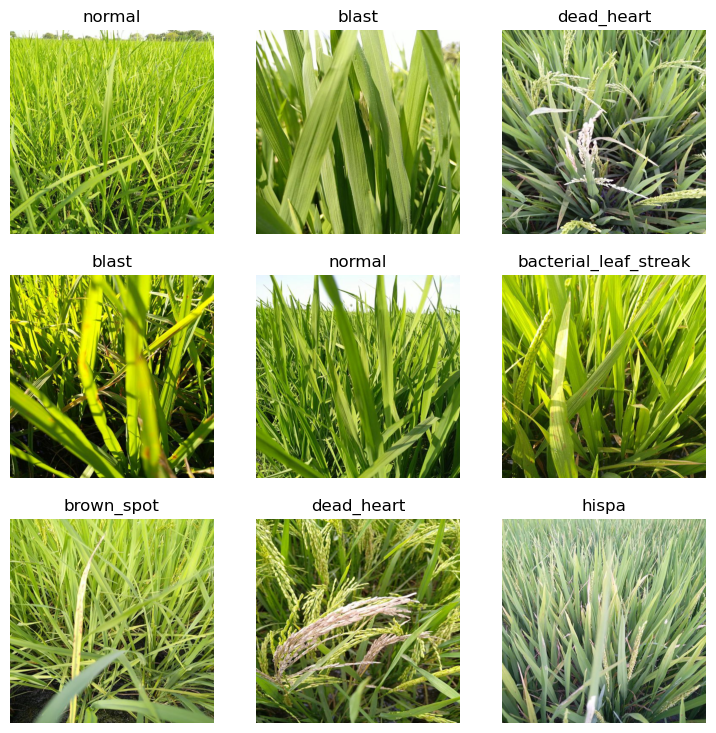

In [ ]:
dls = ImageDataLoaders.from_folder(
        Config['path']/'train_images', 
        valid_pct=.2, 
        item_tfms=Resize(480, method='squish'), 
        batch_tfms=[AlbumentationsTransform(get_train_aug(240), get_valid_aug())], 
        bs=64,
    )
dls.show_batch()

In [ ]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [ ]:
idxs = avg_preds.argmax(1)
vocab = np.array(dls.vocab)
print('idxs:', idxs.shape)
print('vocab:', vocab.shape)

idxs: torch.Size([3469])
vocab: (10,)


In [ ]:
result = vocab[idxs]
result

array(['hispa', 'normal', 'hispa', ..., 'normal', 'bacterial_leaf_streak',
       'dead_heart'], dtype='<U24')

In [ ]:
ss = pd.read_csv(Config['path']/'sample_submission.csv')
ss['label'] = result
ss.to_csv('submission.csv')

,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,hispa
3,200004.jpg,blast
4,200005.jpg,blast
...,...,...
3464,203465.jpg,dead_heart
3465,203466.jpg,hispa
3466,203467.jpg,normal
3467,203468.jpg,bacterial_leaf_streak
